# Panini: Upload CNN model to panini. 

### What is Panini?
Panini is a platform that makes it super easy to deploy AI models in the cloud. Once, deployed in the cloud we will provide you with an API key to infer the model. Our backend is written in C++, which provides very low latency during model inference and the model is stored in Kubernetes so, it is scalable to multiple nodes. We take care of caching and batching inputs during model inference.

### Tradional Approach
The traditional approach is to use Flask, Gunicorn with Nginx. This requires a lot of setup time. Also, inferring model with flask is slow and requires custom code for caching and batching. Scaling in multiple machines is also hard.



### Kaggle Dogs vs Cats dataset
Dataset can be downloaded from https://www.kaggle.com/c/dogs-vs-cats

We will be using DenseNet to classify if a picture is a dog/cat


### Requirements:
###### -Pytorch 1.0
###### -Python 3.6

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [24]:
data_dir = 'Cat_Dog_data'
# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [25]:
model = models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [26]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);



### Train our model
I've already trained our model and saved the weights as last_layers.pth

In [ ]:
# epochs = 1
# steps = 0
# running_loss = 0
# print_every = 5
# for epoch in range(epochs):
#     for inputs, labels in trainloader:
#         steps += 1
#         # Move input and label tensors to the default device
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         optimizer.zero_grad()
        
#         logps = model.forward(inputs)
#         loss = criterion(logps, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
        
#         if steps % print_every == 0:
#             test_loss = 0
#             accuracy = 0
#             model.eval()
#             with torch.no_grad():
#                 for inputs, labels in testloader:
#                     inputs, labels = inputs.to(device), labels.to(device)
#                     logps = model.forward(inputs)
#                     batch_loss = criterion(logps, labels)
                    
#                     test_loss += batch_loss.item()
                    
#                     # Calculate accuracy
#                     ps = torch.exp(logps)
#                     top_p, top_class = ps.topk(1, dim=1)
#                     equals = top_class == labels.view(*top_class.shape)
#                     accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
#             print(f"Epoch {epoch+1}/{epochs}.. "
#                   f"Train loss: {running_loss/print_every:.3f}.. "
#                   f"Test loss: {test_loss/len(testloader):.3f}.. "
#                   f"Test accuracy: {accuracy/len(testloader):.3f}")
#             running_loss = 0
#             model.train()
            
# torch.save(model.classifier.state_dict(),'last_layers.pth')


In [27]:
model.classifier.load_state_dict(torch.load('last_layers.pth',map_location='cpu'))

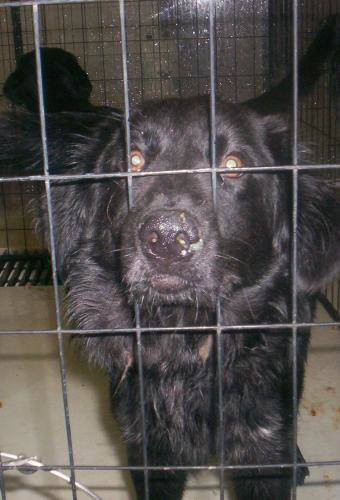

In [28]:
from PIL import Image
from torchvision import transforms




preprocess = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

data_dir_cat = 'Cat_Dog_data/test/cat/cat.10009.jpg'
data_dir_dog = 'Cat_Dog_data/test/dog/dog.10059.jpg'

# response = requests.get(IMG_URL)
# img_pil = Image.open(io.BytesIO(response.content))
img_pil = Image.open(data_dir_dog)
img_tensor = preprocess(img_pil)
img_tensor.shape
inputs_c = img_tensor.view(1,3,224,-1)
img_pil

In [29]:
model.eval()
model.cpu()
logps = model.forward(inputs_c)
logps

tensor([[-2.1618, -0.1223]])

In [30]:
ps = torch.exp(logps)
top_p, top_class = ps.topk(1, dim=1)
top_p, top_class
ps

tensor([[ 0.1151,  0.8849]])

In [31]:
return_label = ""
if top_class == 0:
    return_label = "Cat Prob:{}".format(top_p)
else:
    return_label = "Dog Prob:{}".format(top_p)


    
    
return_label

'Dog Prob:tensor([[ 0.8849]])'

### You need to upload at least 3 files to panini:
##### -predict.py
##### -requirements.txt
##### -savedmodel.pth


Predict.py should have two functions inside: load(path) and predict(model,input)

predict.py should have two functions:
- def load(path): path -> saved state_dict has to be stored as .pth
- def predict(model, inputs): -> inputs is a list[]

```python
#Name of the file: predict.py

def load(path):
    # 1. import everything such as torch and numpy...
    
    # 2. define model architecture 
    #ie. 
    model = nn.Sequential(nn.Linear(....),nn.Relu(),nn.Softmax())
    
    # 3. load the model weights
    model.load_state_dict(torch.load(path,map_location='cpu'))
    
    # 4. load() must return model
    return model

def predict(model,input_from_client):
    # 1. import everything needed such as torch and numpy...
    
    # 2. preproces such as calling transforms.compose()
    
    # 3. input_from_client will be a list. Even if only one image is send
    #loop through input_from_client
    for img in input_from_client:
        #convert img into tensor using preprocess
        
    # 4. forward pass the data to the model. Make sure to use model.eval() mode
    model_output = model(...)
    
    # 5. return the output back to user
    retrun model_output
    
    #Make sure return output must be the same length as the model output. Since our will output two tensor, ie 
    #softmax of dog or cat final return variable needs to have return length of two.
```

In [34]:
#predict.py
#Save this cell, in a seperate file as predict.py

def load(path):
    # 1. import everything needed 
    import torch
    from torch import nn
    from torch import optim
    import torch.nn.functional as F
    from torchvision import datasets, transforms, models
    
    # 2. defie model architecture
    model = models.densenet121(pretrained=True)

    #Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False

    from collections import OrderedDict
    model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))
    
    # 3. load weights
    model.classifier.load_state_dict(torch.load(path,map_location='cpu'))
    
    # 4. return weights loaded model
    return model
    

    
def predict(model,input_image_client):
    # 1. import everything needed again.
    import torch
    from torch import nn
    from torch import optim
    import torch.nn.functional as F
    from torchvision import datasets, transforms, models
    
    import PIL.Image
    import io

    from torchvision import transforms
    
    # 2. define preprocess for the input
    preprocess = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
    
    # 3. input from user will come as a list, even if there is only one input. Loop through the input and apply 
    #transofrm to each input and convert into tensor.
    for input_img in input_image_client:
        img_tensor = preprocess(PIL.Image.open(io.BytesIO(input_img)))[:3] #Just use 3 channels
        img_tensor = img_tensor.view(1,3,224,-1)

    return_label = ""

    # 4.  We perform a forward pass image tensor into our model
    with torch.no_grad():
        model.eval()
        model.cpu()
        logps = model(img_tensor)
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        if top_class == 0:
            return_label = "Cat Prob:{}".format(top_p)
        else:
            return_label = "Dog Prob:{}".format(top_p)

    # 5. length of return variable must be equal to final output from model. In our case
    # very last layer in our model is nn.Linear(256, 2). So, it is expecting list with length of 2.
    # I'm just adding dummy value of 1 to make list length of two.
    
    return_label = [return_label,1]
    
    # 5. return the prediction back to the user
    return return_label


### Infer the model from API link

In [33]:
import base64
import json
import requests

req_json = json.dumps({
        "input":
        base64.b64encode(open('Cat_Dog_data/test/cat/cat.10009.jpg', "rb").read()).decode() # bytes to unicode
    })

response = requests.post(
     "https://api.panini.ai/9kg0cmjx8ncvjjx2kktwqkzfrvo2-catdog/predict",
     headers={"Content-type": "application/json"},
     data=req_json)
response.json()

{'query_id': 29, 'output': 'Cat Prob:tensor([[0.9999]])', 'default': False}